<a id="1"></a>
## Data preprocessing
[Back to the top](#0)

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose

In [38]:
df = pd.read_csv("monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv")
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN


In [39]:
df_test = df[df['MONAT'] == "202101"]
df_test

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
38,Alkoholunfälle,insgesamt,2021,202101,16.0,28.0,23.08,-42.86,35.0
360,Alkoholunfälle,Verletzte und Getötete,2021,202101,5.0,11.0,-44.44,-54.55,20.0
682,Fluchtunfälle,insgesamt,2021,202101,521.0,791.0,-24.93,-34.13,813.0
1004,Fluchtunfälle,Verletzte und Getötete,2021,202101,8.0,28.0,-75.76,-71.43,37.0
1326,Verkehrsunfälle,insgesamt,2021,202101,2149.0,3139.0,-19.24,-31.54,3120.0
1648,Verkehrsunfälle,mit Personenschäden,2021,202101,157.0,301.0,-41.85,-47.84,398.0
1970,Verkehrsunfälle,Verletzte und Getötete,2021,202101,177.0,360.0,-43.09,-50.83,460.0


In [40]:
filtered_df = df[df['JAHR'] <= 2020]
filtered_df = pd.concat([df_test, filtered_df], ignore_index=True, axis=0)

In [41]:
filtered_df.sort_values(by='JAHR', ascending=False).head(10)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2021,202101,16.0,28.0,23.08,-42.86,35.0
4,Verkehrsunfälle,insgesamt,2021,202101,2149.0,3139.0,-19.24,-31.54,3120.0
6,Verkehrsunfälle,Verletzte und Getötete,2021,202101,177.0,360.0,-43.09,-50.83,460.0
5,Verkehrsunfälle,mit Personenschäden,2021,202101,157.0,301.0,-41.85,-47.84,398.0
1,Alkoholunfälle,Verletzte und Getötete,2021,202101,5.0,11.0,-44.44,-54.55,20.0
3,Fluchtunfälle,Verletzte und Getötete,2021,202101,8.0,28.0,-75.76,-71.43,37.0
2,Fluchtunfälle,insgesamt,2021,202101,521.0,791.0,-24.93,-34.13,813.0
279,Alkoholunfälle,Verletzte und Getötete,2020,Summe,250.0,227.0,NaN,10.13,NaN
1640,Verkehrsunfälle,Verletzte und Getötete,2020,202001,360.0,297.0,-4.76,21.21,525.0
1641,Verkehrsunfälle,Verletzte und Getötete,2020,202002,355.0,345.0,-1.39,2.90,526.0


In [42]:
filtered_df = filtered_df[(filtered_df['MONATSZAHL'] == 'Alkoholunfälle') & (filtered_df['AUSPRAEGUNG'] == 'insgesamt')]
filtered_df[(filtered_df['MONATSZAHL'] != 'Alkoholunfälle') | (filtered_df['AUSPRAEGUNG'] != 'insgesamt')].shape[0]

0

In [43]:
filtered_df = filtered_df[['JAHR', 'MONAT', 'WERT']]
filtered_df.head()

,JAHR,MONAT,WERT
0,2021,202101,16.0
7,2020,Summe,430.0
8,2020,202001,28.0
9,2020,202002,40.0
10,2020,202003,27.0


In [44]:
filtered_df.dtypes

JAHR       int64
MONAT     object
WERT     float64
dtype: object

In [45]:
filtered_df = filtered_df[filtered_df['MONAT'].str.isnumeric()]

In [46]:
filtered_df['MONAT'] = filtered_df['MONAT'].astype('int64')

In [47]:
filtered_df.dtypes

JAHR       int64
MONAT      int64
WERT     float64
dtype: object

In [48]:
filtered_df.isna().mean()

JAHR     0.0
MONAT    0.0
WERT     0.0
dtype: float64

In [49]:
filtered_df['MONAT'] = filtered_df['MONAT'] % 100
filtered_df.head()

,JAHR,MONAT,WERT
0,2021,1,16.0
8,2020,1,28.0
9,2020,2,40.0
10,2020,3,27.0
11,2020,4,26.0


In [50]:
filtered_df['Date'] = pd.to_datetime(filtered_df['JAHR'].astype(str) + filtered_df['MONAT'].astype(str), format='%Y%m')
filtered_df.head()

,JAHR,MONAT,WERT,Date
0,2021,1,16.0,2021-01-01
8,2020,1,28.0,2020-01-01
9,2020,2,40.0,2020-02-01
10,2020,3,27.0,2020-03-01
11,2020,4,26.0,2020-04-01


In [51]:
filtered_df = filtered_df.sort_values(by='Date')
filtered_df = filtered_df.reset_index(drop=True)
filtered_df.head()

,JAHR,MONAT,WERT,Date
0,2000,1,78.0,2000-01-01
1,2000,2,53.0,2000-02-01
2,2000,3,73.0,2000-03-01
3,2000,4,78.0,2000-04-01
4,2000,5,96.0,2000-05-01


In [52]:
filtered_df.to_csv('train_data.csv', index=False)

In [53]:
filtered_df.set_index('Date', inplace=True)
filtered_df.head()

,JAHR,MONAT,WERT
Date,,,
2000-01-01,2000,1,78.0
2000-02-01,2000,2,53.0
2000-03-01,2000,3,73.0
2000-04-01,2000,4,78.0
2000-05-01,2000,5,96.0


In [54]:
decomposed = seasonal_decompose(filtered_df['WERT'], model='additive')

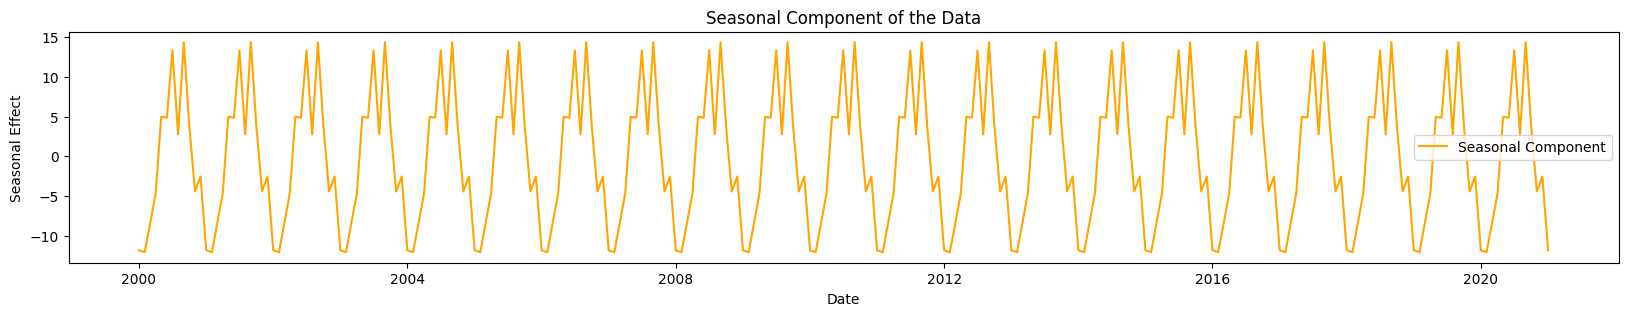

In [55]:
plt.figure(figsize=(20, 3))
plt.plot(decomposed.seasonal, label='Seasonal Component', color='orange')
plt.title('Seasonal Component of the Data')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.legend()
plt.show()

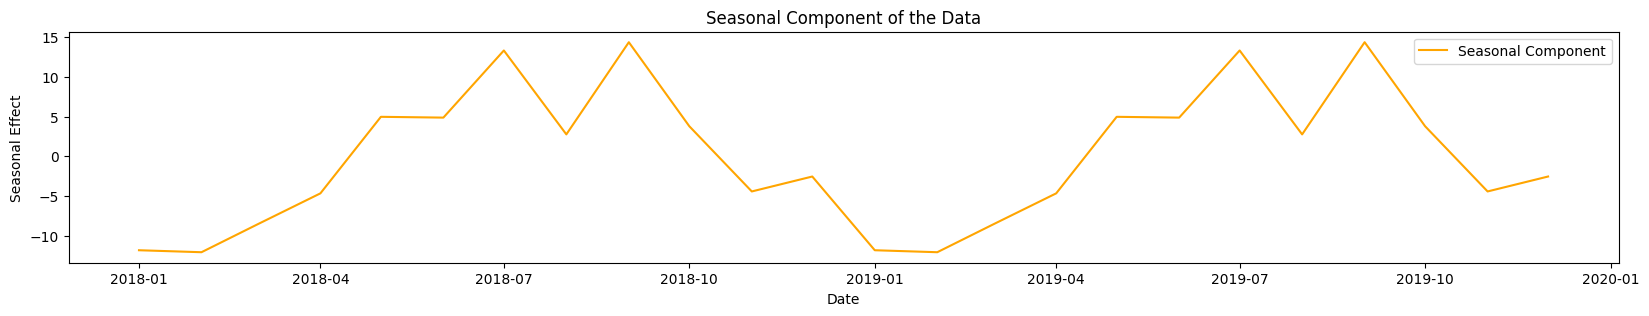

In [56]:
plt.figure(figsize=(20, 3))
plt.plot(decomposed.seasonal["2018-01-01":"2019-12-01"], label='Seasonal Component', color='orange')
plt.title('Seasonal Component of the Data')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.legend()
plt.show()

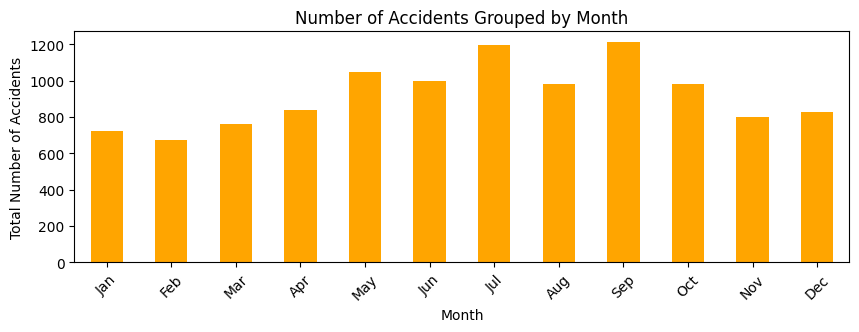

In [57]:
monthly_accidents = filtered_df.groupby(filtered_df.index.month)['WERT'].sum()
plt.figure(figsize=(10, 3))
monthly_accidents.plot(kind='bar', color='orange')
plt.title('Number of Accidents Grouped by Month')
plt.xlabel('Month')
plt.ylabel('Total Number of Accidents')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

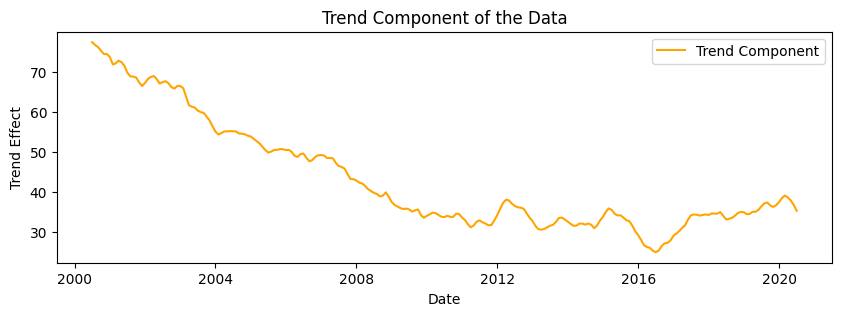

In [58]:
plt.figure(figsize=(10, 3))
plt.plot(decomposed.trend, label='Trend Component', color='orange')
plt.title('Trend Component of the Data')
plt.xlabel('Date')
plt.ylabel('Trend Effect')
plt.legend()
plt.show()

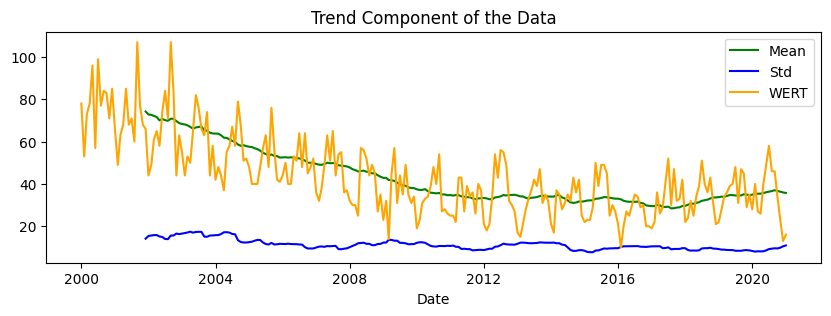

In [59]:
plt.figure(figsize=(10, 3))
plt.plot(filtered_df["WERT"].rolling(24).mean(), label='Mean', color='green')
plt.plot(filtered_df["WERT"].rolling(24).std(), label='Std', color='blue')
plt.plot(filtered_df["WERT"], label='WERT', color='orange')
plt.title('Trend Component of the Data')
plt.xlabel('Date')
plt.legend()
plt.show()

In [60]:
from statsmodels.tsa.stattools import adfuller

In [61]:
result = adfuller(filtered_df["WERT"], regression="ctt")
print("p-value:", result[1])

p-value: 0.028109039167181354


In [62]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data["lag_{}".format(lag)] = data["WERT"].shift(lag)

    data["rolling_mean"] = data["WERT"].shift().rolling(rolling_mean_size).mean()

    return data

In [63]:
filtered_df = make_features(filtered_df, 12, 12)
filtered_df.head()

,JAHR,MONAT,WERT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,,
2000-01-01,2000,1,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,2000,2,53.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,2000,3,73.0,53.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,2000,4,78.0,73.0,53.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2000,5,96.0,78.0,73.0,53.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
train = filtered_df[filtered_df['JAHR'] != 2021]
train = train.dropna()
train

,JAHR,MONAT,WERT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,,
2001-01-01,2001,1,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,53.0,78.0,77.833333
2001-02-01,2001,2,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,53.0,76.833333
2001-03-01,2001,3,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,76.500000
2001-04-01,2001,4,68.0,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,75.666667
2001-05-01,2001,5,85.0,68.0,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,74.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,2020,8,46.0,58.0,49.0,40.0,26.0,27.0,40.0,28.0,35.0,29.0,45.0,47.0,31.0,37.916667
2020-09-01,2020,9,46.0,46.0,58.0,49.0,40.0,26.0,27.0,40.0,28.0,35.0,29.0,45.0,47.0,39.166667
2020-10-01,2020,10,34.0,46.0,46.0,58.0,49.0,40.0,26.0,27.0,40.0,28.0,35.0,29.0,45.0,39.083333


In [66]:
test = filtered_df[filtered_df['JAHR'] == 2021]
test

,JAHR,MONAT,WERT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,,
2021-01-01,2021,1,16.0,13.0,23.0,34.0,46.0,46.0,58.0,49.0,40.0,26.0,27.0,40.0,28.0,35.833333


In [67]:
features_train = train.drop("WERT", axis=1)
target_train = train["WERT"]
features_test = test.drop("WERT", axis=1)
target_test = test["WERT"]

In [68]:
features_train.shape

(240, 15)

In [69]:
features_train.head()

,JAHR,MONAT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,
2001-01-01,2001,1,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,53.0,78.0,77.833333
2001-02-01,2001,2,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,53.0,76.833333
2001-03-01,2001,3,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,76.500000
2001-04-01,2001,4,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,75.666667
2001-05-01,2001,5,68.0,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,74.833333


In [70]:
features_test.shape

(1, 15)

In [71]:
features_test.head()

,JAHR,MONAT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,
2021-01-01,2021,1,13.0,23.0,34.0,46.0,46.0,58.0,49.0,40.0,26.0,27.0,40.0,28.0,35.833333


In [72]:
features_train_linear = features_train.copy()
features_test_linear = features_test.copy()

In [74]:
numeric = features_train.columns.tolist()
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None
features_train_linear[numeric] = scaler.transform(features_train[numeric])
features_test_linear[numeric] = scaler.transform(features_test[numeric])

In [76]:
features_train_linear.head()

,JAHR,MONAT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,
2001-01-01,-1.647509,-1.593255,2.566403,1.706325,2.386182,2.406574,1.972878,3.176937,0.782434,2.933677,1.905336,1.611075,0.501070,1.861847,2.545482
2001-02-01,-1.647509,-1.303572,1.423105,2.545993,1.674700,2.348002,2.379557,1.924100,3.171690,0.755238,2.905100,1.887774,1.607389,0.486775,2.471838
2001-03-01,-1.647509,-1.013890,0.400154,1.406444,2.504763,1.645139,2.321460,2.322730,1.920175,3.101249,0.738946,2.883887,1.883968,1.586832,2.447290
2001-04-01,-1.647509,-0.724207,1.242584,0.386847,1.378250,2.465146,1.624296,2.265783,2.318385,1.872386,3.071727,0.725641,2.879655,1.861847,2.385921
2001-05-01,-1.647509,-0.434524,1.543452,1.226515,0.370317,1.352279,2.437654,1.582418,2.261497,2.263388,1.849794,3.049906,0.722334,2.851898,2.324551


In [77]:
features_test_linear.head()

,JAHR,MONAT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,
2021-01-01,1.820931,-1.593255,-1.766095,-1.172536,-0.519036,0.180841,0.17187,0.842105,0.327338,-0.194337,-0.982869,-0.934548,-0.218037,-0.888296,-0.547544


In [84]:
%%time
model = LinearRegression()
time_split = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(
    model, features_train_linear, target_train, scoring='neg_root_mean_squared_error', cv=time_split, n_jobs=-1
)
print("RMSE of linear regression model on training set:", (scores * (-1)).min())

RMSE of linear regression model on training set: 8.233787980025122
CPU times: total: 0 ns
Wall time: 2.29 s


In [85]:
RANDOM_STATE = 12345

In [99]:
%%time
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {"max_depth": range(1, 10, 1)}
grid_tr = GridSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_tr.fit(features_train, target_train)
print(
    "Best hyperparameters for Decision Tree on the training set:",
    grid_tr.best_params_,
)
print(
    "RMSE of Decision Tree on the training set:",
    (grid_tr.best_score_ * (-1)),
)

Best hyperparameters for Decision Tree on the training set: {'max_depth': 2}
RMSE of Decision Tree on the training set: 11.065271280102667
CPU times: total: 31.2 ms
Wall time: 122 ms


In [117]:
%%time
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {"max_depth": range(1, 10, 1)}
rand_tr = RandomizedSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
rand_tr.fit(features_train, target_train)
print(
    "Best hyperparameters for Decision Tree on the training set:",
    rand_tr.best_params_,
)
print(
    "RMSE of Decision Tree on the training set:",
    (rand_tr.best_score_ * (-1)),
)

C:\Users\Sereb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters for Decision Tree on the training set: {'max_depth': 2}
RMSE of Decision Tree on the training set: 11.065271280102667
CPU times: total: 93.8 ms
Wall time: 523 ms


In [109]:
%%time
model = RandomForestRegressor(random_state=RANDOM_STATE)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {"n_estimators": range(1, 50, 1)}
grid_rf = GridSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error')
grid_rf.fit(features_train, target_train)
print(
    "Best hyperparameters for Random Forest on the training set:",
    grid_rf.best_params_,
)
print(
    "RMSE of Random Forest on the training set:",
    (grid_rf.best_score_ * (-1)),
)

Best hyperparameters for Random Forest on the training set: {'n_estimators': 7}
RMSE of Random Forest on the training set: 8.848428615392509
CPU times: total: 6.94 s
Wall time: 12.2 s


In [113]:
%%time
model = RandomForestRegressor(random_state=RANDOM_STATE)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {"n_estimators": range(1, 50, 1)}
rand_rf = RandomizedSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
rand_rf.fit(features_train, target_train)
print(
    "Best hyperparameters for Random Forest on the training set:",
    rand_rf.best_params_,
)
print(
    "RMSE of Random Forest on the training set:",
    (rand_rf.best_score_ * (-1)),
)

Best hyperparameters for Random Forest on the training set: {'n_estimators': 9}
RMSE of Random Forest on the training set: 8.931907491647735
CPU times: total: 203 ms
Wall time: 1.02 s


In [ ]:
%%time
model = CatBoostRegressor(loss_function="RMSE")
time_split = TimeSeriesSplit(n_splits=5)
parameters = {'depth' : range(1, 10, 1),
              'learning_rate' : [0.12, 0.13, 0.14],
              'iterations'    : [94, 95, 96]
              }
grid_CBR = GridSearchCV(model, param_grid = parameters, cv = time_split, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_CBR.fit(features_train, target_train, verbose = 10)
print(
    "Best hyperparameters for CatBoostRegressor on the training set:",
    grid_CBR.best_params_,
)
print(
    "RMSE of CatBoostRegressor on the training set:",
    (grid_CBR.best_score_ * (-1)),
)

0:	learn: 15.3411062	total: 981us	remaining: 92.2ms
10:	learn: 9.6775802	total: 9.88ms	remaining: 75.4ms
20:	learn: 8.1735545	total: 17.8ms	remaining: 62.6ms
30:	learn: 7.5175634	total: 26.4ms	remaining: 54.5ms
40:	learn: 7.0638681	total: 34.2ms	remaining: 45ms
50:	learn: 6.7347166	total: 43.8ms	remaining: 37.7ms
60:	learn: 6.4864909	total: 54.3ms	remaining: 30.2ms
70:	learn: 6.1826703	total: 64.1ms	remaining: 21.7ms
80:	learn: 5.9055858	total: 73.4ms	remaining: 12.7ms
90:	learn: 5.6522746	total: 83.3ms	remaining: 3.66ms
94:	learn: 5.4959889	total: 86.7ms	remaining: 0us
Best hyperparameters for Gradient Boosting on the training set: {'depth': 3, 'iterations': 95, 'learning_rate': 0.13}
RMSE of Gradient Boosting on the training set: 9.228449840219955
CPU times: total: 1.77 s
Wall time: 51.1 s


In [ ]:
%%time
model = CatBoostRegressor(loss_function="RMSE")
time_split = TimeSeriesSplit(n_splits=5)
parameters = {'depth' : range(1, 10, 1),
              'learning_rate' : [0.12, 0.13, 0.14],
              'iterations'    : [94, 95, 96]
              }
rand_CBR = RandomizedSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
rand_CBR.fit(features_train, target_train, verbose = 10)
print(
    "Best hyperparameters for CatBoostRegressor on the training set:",
    rand_CBR.best_params_,
)
print(
    "RMSE of CatBoostRegressor on the training set:",
    (rand_CBR.best_score_ * (-1)),
)

0:	learn: 15.3411062	total: 1.1ms	remaining: 105ms
10:	learn: 9.6775802	total: 9.74ms	remaining: 75.2ms
20:	learn: 8.1735545	total: 18.5ms	remaining: 66.2ms
30:	learn: 7.5175634	total: 25.9ms	remaining: 54.3ms
40:	learn: 7.0638681	total: 33.9ms	remaining: 45.5ms
50:	learn: 6.7347166	total: 41.2ms	remaining: 36.4ms
60:	learn: 6.4864909	total: 48.5ms	remaining: 27.8ms
70:	learn: 6.1826703	total: 55.3ms	remaining: 19.5ms
80:	learn: 5.9055858	total: 63.3ms	remaining: 11.7ms
90:	learn: 5.6522746	total: 70.2ms	remaining: 3.86ms
95:	learn: 5.4774416	total: 74ms	remaining: 0us
Best hyperparameters for Gradient Boosting on the training set: {'learning_rate': 0.13, 'iterations': 96, 'depth': 3}
RMSE of Gradient Boosting on the training set: 9.251787049478741
CPU times: total: 172 ms
Wall time: 6.7 s


In [152]:
%%time
model = lgb.LGBMRegressor(verbosity= -1)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {'max_depth' : range(1, 10, 1),
              'learning_rate' : [0.12, 0.13, 0.14],
              'n_estimators'    : [94, 95, 96]
              }
grid_lgb = GridSearchCV(model, param_grid = parameters, cv = time_split, scoring='neg_root_mean_squared_error')
grid_lgb.fit(features_train, target_train)
print(
    "Best hyperparameters for LGBMRegressor on the training set:",
    grid_lgb.best_params_,
)
print(
    "RMSE of LGBMRegressor on the training set:",
    (grid_lgb.best_score_ * (-1)),
)

Best hyperparameters for LGBMRegressor on the training set: {'learning_rate': 0.13, 'max_depth': 1, 'n_estimators': 95}
RMSE of LGBMRegressor on the training set: 11.661443591957708
CPU times: total: 16.2 s
Wall time: 11.1 s


In [154]:
%%time
model = lgb.LGBMRegressor(verbosity= -1)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {'max_depth' : range(1, 10, 1),
              'learning_rate' : [0.12, 0.13, 0.14],
              'n_estimators'    : [94, 95, 96]
              }
rand_lgb = RandomizedSearchCV(model, parameters, cv = time_split, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE)
rand_lgb.fit(features_train, target_train)
print(
    "Best hyperparameters for LGBMRegressor on the training set:",
    rand_lgb.best_params_,
)
print(
    "RMSE of LGBMRegressor on the training set:",
    (rand_lgb.best_score_ * (-1)),
)

Best hyperparameters for LGBMRegressor on the training set: {'n_estimators': 95, 'max_depth': 1, 'learning_rate': 0.13}
RMSE of LGBMRegressor on the training set: 11.661443591957708
CPU times: total: 3.41 s
Wall time: 1.47 s


In [156]:
model = LinearRegression()
model.fit(features_train_linear, target_train)
pred = model.predict(features_test_linear)
pred

array([20.29543033])

In [160]:
target_test

Date
2021-01-01    16.0
Name: WERT, dtype: float64